使用过OpenSees(以下简称OS，注意大小写拼写，其余的都是错的哦，scott教授在一个视频里强调了好几遍 :smile: )的朋友们肯定都体验过创建纤维截面时的痛苦，OS只提供了几种规则形状的命令(点，线，矩形，四边形，圆(扇)形)，当你的截面不规则乃至构件是变截面时，写纤维命令简直太痛苦。而且，如果你想做参数化分析，生成纤维截面更是难上加难。鉴于此，我最近重构了以前写的截面纤维划分的python脚本接口，使用几行命令即可创造出任意截面的纤维划分。
如下是做测试时用的几个例子

# 环境依赖

环境依赖有  shapely, pygmsh, OpenSeesPy, numpy, matpltlib 这几个包
* 其中 numpy 和 matplotlib 如果你安装了 Anaconda 软件会自带；
* OpenSeesPy 是 OpenSees 的 python 封装包，强烈建议在 python 中使用 OpenSees;
* shapely 是一个几何库，它是对 GEOS 这个库的 python 封装；
* pygmsh 是对网格划分包 gmsh 的一个python封装。其实gmsh本身也提供了python接口，但是非常繁琐。这个pygmsh设计的挺不错的，于是就选择用它，毕竟少写代码，少掉头发。

安装这些包非常简单，使用 ***pip install shapely pygmsh***  即可自动安装包及其依赖

我已经给模块命名为 ***SecMesh***, 所以下面使用时皆从该模块中导入。

该文件已托管至我的 gitee 账号，欢迎下载使用，https://gitee.com/yexiang-yan/ops_utility

目前仅支持如下几个截面类型：
- 单一材料截面：SecPlain 类
- 钢筋混凝土截面：SecRC 类
- 钢骨混凝土截面： SecSRC 类
- 钢管混凝土截面： SecSTC 类

# 创建单一材料截面

所谓单一材料截面是指截面只有一种材料组成，可以是钢截面，也可以是混凝土，可以包含钢筋。
单一材料截面被定义在类 SecPlain 中，该类提供了如下几个类方法接口：
* add_outline(points)： 为截面增加外轮廓线，参数points是一个列表形状的数据，其中包含了外轮廓线的坐标点，
                        这些点之间为直线段，因此你只要输入截面轮廓的控制点就可以了，点闭合不闭合都可以，
                        因为内部设置了自动闭合
* add_hole(points): 运行一次就会为截面增加一个开口，参数 points 和 add_outline 相同。
* add_rebar_outline(dia, gap, d): 增加一个与外轮廓线保持相同形状的钢筋环，dia是直径，gap是钢筋之间中心间距，d是钢筋外边缘与截面轮廓线间的距离，也就是说这些钢筋是根据外轮廓线偏移得到的
* add_rebar_hole(dia, gap, d)：根据内部开口的形状偏移得到钢筋
* add_rebar_line(self, points, dia, gap)：增加任意的钢筋形状，points如上描述，可以输入控制点(只要点之间是直线即可)，程序会根据gap自动剖分
* mesh(mesh_size): 根据尺寸 mesh_size 划分截面三角形纤维
* centring(): 中心化截面，也就是说上述坐标点可以是任意的，程序会自动把中心转移到原点。
* rotate(theta=0)：顺时针转动截面，譬如 theta=90 ，会顺时针转动截面90度
* sec_props(): 返回截面特性
* mesh_view(fill=True, show_mesh_order=True)： 可视化截面，fill为True的化会用颜色填充多边形；否则绘制网格。show_mesh_order=True会增加一个网格绘制次序图例，后面如果想生成OpenSees命令，传入的材料号顺序应与该顺序相同。

以下是案例，使用非常简单

## 多边形截面

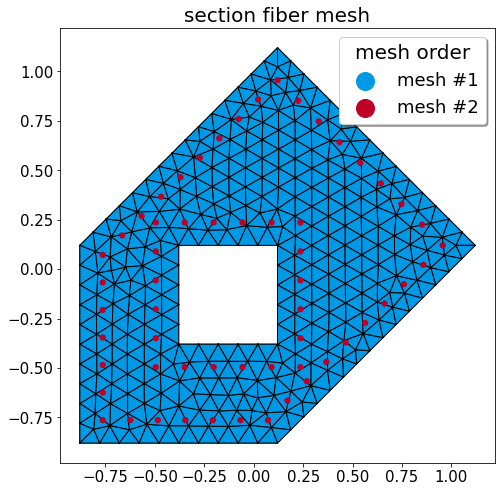

In [1]:
from SecMesh import SecPlain   # 导入类
points = [[0, 0], [1, 0], [2, 1], [1, 2], [0, 1]]    # 因为是五边形，所以只需要输入五个顶点坐标即可
hole = [(0.5, 0.5), (1.0, 0.5), (1, 1), (0.5, 1)]
sec = SecPlain()   # 实例化类
sec.add_outline(points)  # 增加外轮廓线
sec.add_hole(hole)  # 增加开口，注意开口只能一个个增加，可以试下注释掉该行
sec.add_rebar_outline(dia=0.032, gap=0.15, d=0.1)   # 根据外轮廓线偏移钢筋
sec.add_rebar_hole(dia=0.032, gap=0.15, d=0.1)   # 根据开口偏移钢筋
sec.mesh(mesh_size=0.1)   # 划分纤维
sec.rotate(theta=0)   # 转动截面，可以试下其他角度
sec.centring()    # 中心化
sec.mesh_view()   # 可视化，show_mesh_order改为False,则不显示图例

## 圆形截面

我们可以使用以直代曲来绘制圆形截面，注意曲线的分割点数量不可过多，过密不然会覆盖掉你的纤维尺寸，建议分成20-30段即可；

其他包括直线曲线混合的截面也类似

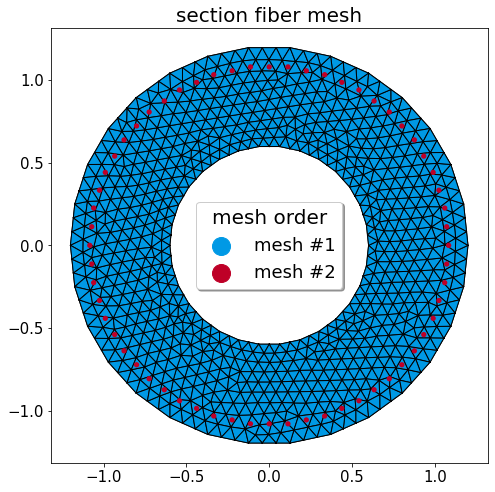

In [2]:
import numpy as np

sec = SecPlain() 
# 如下创建圆形轮廓 
points = []
n = 30
r = 1.2   # 圆半径
for angle in np.linspace(0, 2 * np.pi, n, endpoint=False):   # endpoint 需要设置为 False
    points.append((r * np.cos(angle), r * np.sin(angle)))
# 创建开口点
hole = []
r = 0.6
for angle in np.linspace(0, 2 * np.pi, n, endpoint=False):
    hole.append((r * np.cos(angle), r * np.sin(angle)))
sec.add_outline(points)
sec.add_rebar_outline(dia=0.032, gap=0.15, d=0.1)
sec.add_hole(hole)
sec.mesh(mesh_size=0.1)   #  可以试下 如果 n 设置太多，mesh_size 不会再控制你的纤维尺寸，而是由n控制， 这个bug以后再想法解决，但是30似乎就够圆了
# h.centring()
sec.mesh_view()

# 钢筋混凝土截面

与单一材料截面不同的是，钢筋混凝土截面多了保护层。对应的类是 SecRC。

因此该类除了具有 SecPlain 所有接口外，多了一个 add_cover(d) 命令，增加一个厚度为d的保护层

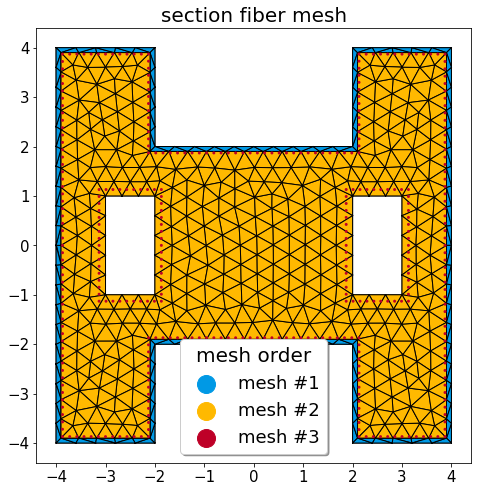

In [3]:
from SecMesh import SecRC

points = [(-4, 4), (-2, 4), (-2, 2), (2, 2), (2, 4), (4, 4),
             (4, -4), (2, -4), (2, -2), (-2, -2), (-2, -4), (-4, -4)]
holes = [[(-3, 1), (-2, 1), (-2, -1), (-3, -1)],
            [(3, 1), (2, 1), (2, -1), (3, -1)]]
sec = SecRC()   #  实例化
sec.add_outline(points)
sec.add_cover(d=0.1)    #  增加一个厚度为0.1 的保护层
for hole in holes:
    sec.add_hole(hole)   # 一次增加一个开口
sec.add_rebar_outline(dia=0.06, gap=0.15, d=0.1)
sec.add_rebar_hole(dia=0.06, gap=0.15, d=0.1)
sec.mesh(mesh_size=0.4)
sec.rotate(theta=0)
sec.centring()
sec.mesh_view(fill=True)

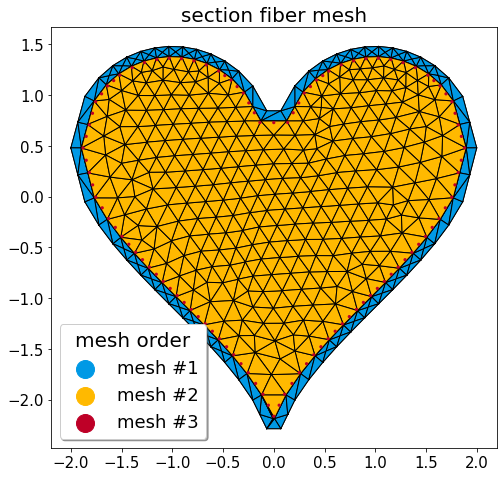

In [4]:
import numpy as np

x = np.linspace(-2, 2, 30)
y1 = np.sqrt(1 - (np.abs(x) - 1) * (np.abs(x) - 1))
y2 = np.arccos(1 - np.abs(x)) - np.pi
lines = [(xi, yi) for xi, yi in zip(x, y1)]
lines_ = [(xi, yi) for xi, yi in zip(x[-2:0:-1], y2[-2:0:-1])]
lines.extend(lines_)
sec = SecRC()   #  实例化
sec.add_outline(lines)
sec.add_cover(d=0.1)    #  增加一个厚度为0.1 的保护层
sec.add_rebar_outline(dia=0.032, gap=0.15, d=0.1)
sec.add_rebar_hole(dia=0.02, gap=0.15, d=0.1)
sec.mesh(mesh_size=0.3)
sec.rotate(theta=0)
sec.centring()
sec.mesh_view(fill=True)

# 钢骨混凝土截面

对应的类为 SecSRC

比 RC 截面类又多了一个 增加钢骨的命令

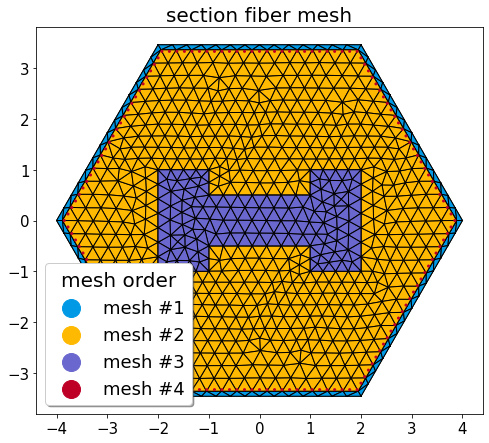

In [5]:
from SecMesh import SecSRC

points = []
r = 4
for angle in np.linspace(0, 2 * np.pi, 6, endpoint=False):
    points.append((r * np.cos(angle), r * np.sin(angle)))
bone = [(-2, 1), (-1, 1), (-1,0.5), (1, 0.5), (1, 1), (2, 1),
        (2, -1), (1, -1), (1,-0.5), (-1, -0.5), (-1, -1), (-2, -1)]
h = SecSRC()
h.add_outline(points)   # 外轮廓线
h.add_cover(d=0.1)      # 保护层
h.add_rebar_outline(dia=0.06, gap=0.15, d=0.1)   # 偏移得到钢筋线
h.add_steel_bone(bone)   # 增加钢骨，类似开口，一个个增加
h.mesh(mesh_size=0.3)
h.rotate(theta=0)
h.centring()
h.mesh_view()

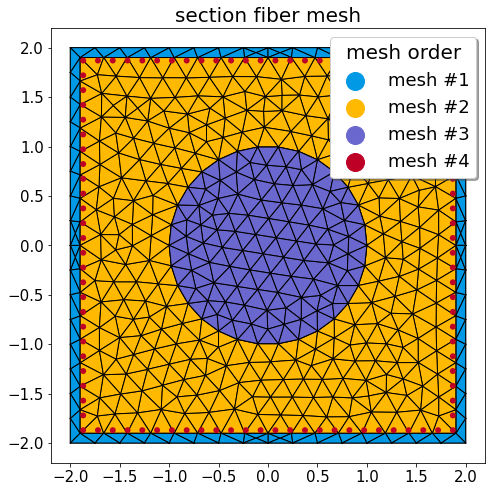

In [6]:
lines = [(-2, 2), (2, 2), (2, -2), (-2, -2)]
bone = []
r = 1
n = 30
for angle in np.linspace(0, 2 * np.pi, n, endpoint=False):
    bone.append((r * np.cos(angle), r * np.sin(angle)))
h = SecSRC()
h.add_outline(lines)
h.add_cover(d=0.1)
h.add_rebar_outline(dia=0.06, gap=0.15, d=0.1)
h.add_steel_bone(bone)
h.mesh(mesh_size=0.25)
h.rotate(theta=0)
h.centring()
h.mesh_view()

# 钢管混凝土截面 

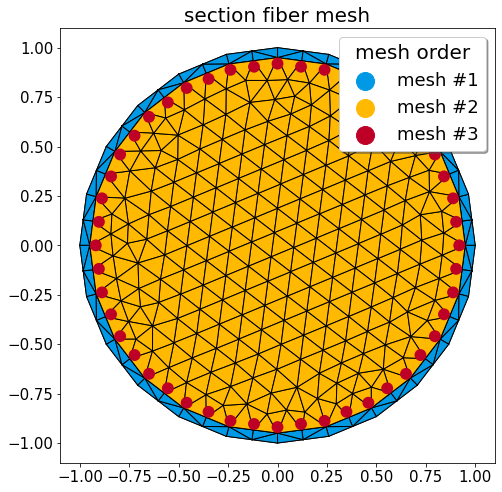

In [7]:
from SecMesh import SecSTC

lines = []
r = 1
for angle in np.linspace(0, 2 * np.pi, 24, endpoint=False):
    lines.append((r * np.cos(angle), r * np.sin(angle)))
h = SecSTC()
h.add_outline(lines)     # 外轮廓线
h.add_steel_tube(d=0.05)  # 增加钢管层，厚度为d
h.add_rebar_tube(dia=0.06, gap=0.15, d=0.05)   # 根据外轮廓线偏移钢筋
h.mesh(mesh_size=0.2)
# h.rotate(theta=0)
h.centring()
h.mesh_view()

# 生成 OpenSees 命令

以上只是划分了纤维，另外一个重要的东西是如何生成 OpenSees 命令呢？

这里提供了两个接口，都是直接生成点纤维，坐标就是每个三角形的中心，面积就是三角形的面积
* 一个是 直接生成 OpenSeesPy 命令，直接在python中调用：ops_cmds_py(self, secTag: int, matTags: ArrayLike, GJ: float)
* 一个是 生成 tcl 命令的 文件，供 tcl版本读取调用：ops_cmds_tcl(self, output_dir: str, secTag: int, matTags: ArrayLike, GJ: float)

 secTag: 是 要生成的截面号

 matTags: 是 已经定义好的 材料号列表，注意材料号顺序是按照截面从外到内的顺序，mesh_view中显示的图例提示了材料设置顺序。
 
 GJ: 截面扭转刚度

# ops_cmds_py 

进行命令生成之前，假设创建了一个如下模型，定义材料

In [8]:
import openseespy.opensees as ops

# 定义opensees模型中的材料，依次为保护层，核心区混凝土，以及钢筋
ops.wipe()
ops.model('basic', '-ndm', 3, '-ndf', 6)

# 混凝土材料，采用Cncrete01模型，如不确定下面不用改
vc = 0.2  # 混凝土泊松比
fc = -20.1E3  # 混凝土峰值强度
ec = -2.E-3  # 混凝土峰值应变
fcu = -16.5E3  # 混凝土极限强度
ecu = -4.E-3  # 混凝土极限应变
Ec = 2 * fc / ec  # 弹性模量
Gc = Ec / (2 * (1 + vc)) # 剪切模量

# ft40 = 2.39E+3       # 不考虑受拉强度
# et40 = 100.E-6
fccore = -26.8E3  # 约束混凝土峰值强度
eccore = -5.3E-3  # 约束混凝土峰值应变
fcucore = -23.  # 约束混凝土极限强度
ecucore = -0.0157  # 约束混凝土极限应变

# 钢筋材料 （Steel01 Material. ）
Fys = 300.E3  # 屈服应力
Es = 2.0E8  # 钢筋弹性模量
bs = 0.01  # 刚度硬化比
matTagC = 1
matTagCCore = 2
matTagSteel = 3
ops.uniaxialMaterial('Concrete01', matTagC, fc, ec, fcu, ecu)
ops.uniaxialMaterial('Concrete01', matTagCCore,
                    fccore, eccore, fcucore, ecucore)
ops.uniaxialMaterial('Steel01', matTagSteel, Fys, Es, bs)
# 建立节点
ops.node(1, 0.0, 0.0, 0.0)
ops.node(2, 0.0, 0.0, 0.0)
ops.fix(1, *([1]*6))

创建一个 RC 截面

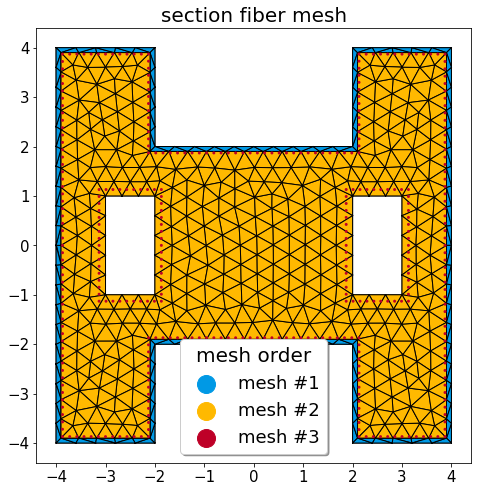

In [9]:
from SecMesh import SecRC

points = [(-4, 4), (-2, 4), (-2, 2), (2, 2), (2, 4), (4, 4),
             (4, -4), (2, -4), (2, -2), (-2, -2), (-2, -4), (-4, -4)]
holes = [[(-3, 1), (-2, 1), (-2, -1), (-3, -1)],
            [(3, 1), (2, 1), (2, -1), (3, -1)]]
sec = SecRC()   #  实例化
sec.add_outline(points)
sec.add_cover(d=0.1)    #  增加一个厚度为0.1 的保护层
for hole in holes:
    sec.add_hole(hole)   # 一次增加一个开口
sec.add_rebar_outline(dia=0.06, gap=0.15, d=0.1)
sec.add_rebar_hole(dia=0.06, gap=0.15, d=0.1)
sec.mesh(mesh_size=0.4)
sec.rotate(theta=0)
sec.centring()
sec.mesh_view(fill=True)

In [10]:
# 生成 命令
matTags = [matTagC, matTagCCore, matTagSteel]
sec_Tag = 1
sec.ops_cmds_py(sec_Tag, matTags, GJ=10000)   # 自动生成命令

为了验证  生成的命令对不对，我们可以使用以前介绍的函数 ops_sec_vis 来从 OpenSees 内部提取截面纤维可视化

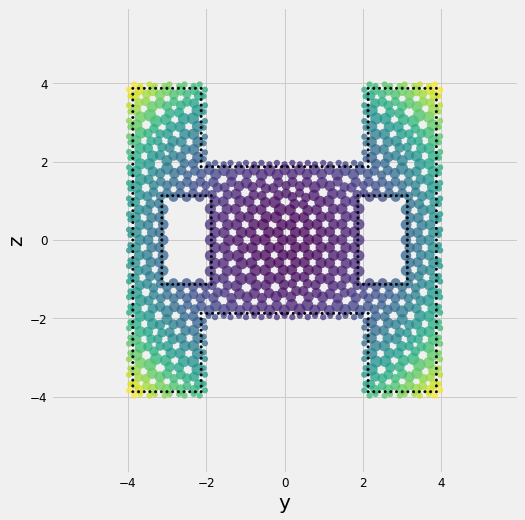

In [11]:
from SecMesh import ops_sec_vis

# ops_sec_vis 必须在单元定义后才可使用
# 定义单元，单元号1
ops.element('zeroLengthSection', 1, 1, 2, sec_Tag)
ops_sec_vis(ele_tag=1, rebar_d=0.06)  # 可视化

可以看到，根据OpenSees内部提取的纤维和我们创造的是一致的，说明 代码ok

# ops_cmds_tcl

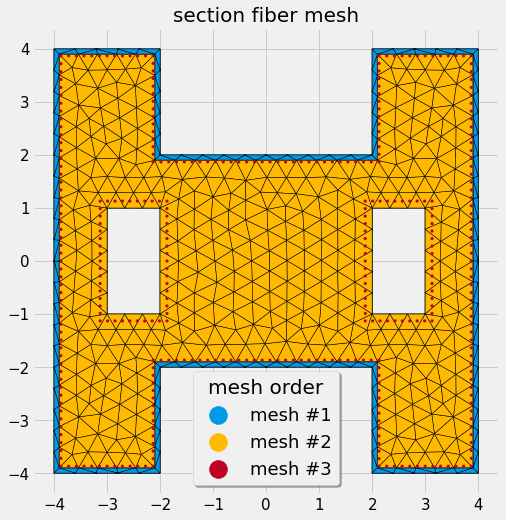

In [12]:
from SecMesh import SecRC

points = [(-4, 4), (-2, 4), (-2, 2), (2, 2), (2, 4), (4, 4),
             (4, -4), (2, -4), (2, -2), (-2, -2), (-2, -4), (-4, -4)]
holes = [[(-3, 1), (-2, 1), (-2, -1), (-3, -1)],
            [(3, 1), (2, 1), (2, -1), (3, -1)]]
sec = SecRC()   #  实例化
sec.add_outline(points)
sec.add_cover(d=0.1)    #  增加一个厚度为0.1 的保护层
for hole in holes:
    sec.add_hole(hole)   # 一次增加一个开口
sec.add_rebar_outline(dia=0.06, gap=0.15, d=0.1)
sec.add_rebar_hole(dia=0.06, gap=0.15, d=0.1)
sec.mesh(mesh_size=0.4)
sec.rotate(theta=0)
sec.centring()
sec.mesh_view(fill=True)

In [13]:
output_dir = "sec_mesh.tcl"   #  多了这么个参数，输出文件
matTags = [1, 2, 3]
sec_Tag = 1
sec.ops_cmds_tcl(output_dir, sec_Tag, matTags, GJ=10000)   # 自动生成命令

看一下生成的 tcl 文件截图， 其中temp_matTag 为临时生成的材料号，方便后续修改

# 截面特性

In [14]:
props = sec.sec_props()
print(props)

{'area': 44.00000000000003, 'center': (5.129735020597595e-15, -9.235036977563796e-16, 0), 'Iy': 190.41472565048613, 'Iz': 294.42365487178506, 'ry': 2.0802902204133464, 'rz': 2.5867830797404476, 'Ip': 484.8383805222712, 'Iyz': 0.00100144291708415}


# 结语

暂时支持这么些功能，日常的使用应该足够了，后续再慢慢增加。

利用上述类代码，你还可以定制任意类型截面的参数化函数或类。譬如你可以定制一个开口矩形截面，利用长、宽、壁厚等参数来生成截面，这里就不再演示了。

如有代码问题，可在gitee中提交，或与本人联系

创作不易，欢迎关注、点赞、转发、支持。谢谢！
